In [1]:
# ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
import eli5

In [3]:
data = pd.read_csv("data/ner_dataset.csv", encoding="utf-8")
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,Tag
369382,Sentence: 16858,vùng,O
369383,Sentence: 16858,chôn_cất,O
369384,Sentence: 16858,người_thân,O
369385,Sentence: 16858,khi,O
369386,Sentence: 16858,qua_đời,O
369387,Sentence: 16858,",",O
369388,Sentence: 16858,gọi,O
369389,Sentence: 16858,là,O
369390,Sentence: 16858,nhị_tì,O
369391,Sentence: 16858,...,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

19152

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

5

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Đó', 'O'), ('là', 'O'), ('con', 'O'), ('đường', 'O'), ('biển', 'O'), ('ngắn', 'O'), ('nhất', 'O'), ('để', 'O'), ('đi', 'O'), ('từ', 'O'), ('Ấn_Độ_Dương', 'LOCATION'), ('sang', 'O'), ('Thái_Bình_Dương', 'LOCATION'), (',', 'O'), ('chiếm', 'O'), ('đến', 'O'), ('lượng', 'O'), ('hàng_hoá', 'O'), ('lưu_thông', 'O'), ('đường_biển', 'O'), ('của', 'O'), ('thế_giới', 'O'), (',', 'O'), ('đó', 'O'), ('là', 'O'), ('hải_trình', 'O'), ('lớn', 'O'), ('nhất', 'O'), ('từ', 'O'), ('tây', 'O'), ('sang', 'O'), ('đông', 'O'), ('với', 'O'), ('50.000', 'O'), ('lượt', 'O'), ('tàu_bè', 'O'), ('qua_lại', 'O'), ('mỗi', 'O'), ('năm', 'O'), ('...', 'O')]


In [12]:
sentences = getter.sentences

In [13]:
max_len = 75
max_len_char = 10

In [14]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
print(word2idx["ông"])
print(tag2idx["ORGANIZATION"])

1136
5


In [16]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [17]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

198


In [18]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [19]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [21]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [22]:
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [24]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)

In [25]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 10)   2000        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       383080      input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [26]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Train on 13654 samples, validate on 1518 samples
Epoch 1/10


 6496/13654 [=============>................] - ETA: 43:27 - loss: 1.7940 - acc: 0.11 - ETA: 22:36 - loss: 1.7887 - acc: 0.33 - ETA: 15:42 - loss: 1.7834 - acc: 0.51 - ETA: 12:11 - loss: 1.7780 - acc: 0.61 - ETA: 10:07 - loss: 1.7721 - acc: 0.68 - ETA: 8:42 - loss: 1.7659 - acc: 0.7193 - ETA: 7:42 - loss: 1.7585 - acc: 0.753 - ETA: 6:57 - loss: 1.7518 - acc: 0.775 - ETA: 6:22 - loss: 1.7449 - acc: 0.793 - ETA: 5:54 - loss: 1.7369 - acc: 0.805 - ETA: 5:31 - loss: 1.7281 - acc: 0.817 - ETA: 5:11 - loss: 1.7189 - acc: 0.825 - ETA: 4:55 - loss: 1.7079 - acc: 0.832 - ETA: 4:40 - loss: 1.6967 - acc: 0.838 - ETA: 4:29 - loss: 1.6858 - acc: 0.843 - ETA: 4:18 - loss: 1.6734 - acc: 0.850 - ETA: 4:08 - loss: 1.6550 - acc: 0.855 - ETA: 4:00 - loss: 1.6385 - acc: 0.859 - ETA: 3:51 - loss: 1.6207 - acc: 0.864 - ETA: 3:44 - loss: 1.5981 - acc: 0.868 - ETA: 3:37 - loss: 1.5719 - acc: 0.870 - ETA: 3:31 - loss: 1.5470 - acc: 0.873 - ETA: 3:25 - loss: 1.5154 - acc: 0.876 - ETA: 3:20 - loss: 1.4857 - acc: 

13376/13654 [============================>.] - ETA: 57s - loss: 0.4758 - acc: 0.92 - ETA: 57s - loss: 0.4744 - acc: 0.92 - ETA: 57s - loss: 0.4735 - acc: 0.92 - ETA: 56s - loss: 0.4720 - acc: 0.92 - ETA: 56s - loss: 0.4711 - acc: 0.92 - ETA: 56s - loss: 0.4703 - acc: 0.92 - ETA: 55s - loss: 0.4692 - acc: 0.92 - ETA: 55s - loss: 0.4686 - acc: 0.92 - ETA: 55s - loss: 0.4679 - acc: 0.92 - ETA: 55s - loss: 0.4669 - acc: 0.92 - ETA: 54s - loss: 0.4660 - acc: 0.92 - ETA: 54s - loss: 0.4649 - acc: 0.92 - ETA: 54s - loss: 0.4636 - acc: 0.92 - ETA: 53s - loss: 0.4626 - acc: 0.92 - ETA: 53s - loss: 0.4619 - acc: 0.92 - ETA: 53s - loss: 0.4606 - acc: 0.92 - ETA: 53s - loss: 0.4596 - acc: 0.92 - ETA: 52s - loss: 0.4587 - acc: 0.92 - ETA: 52s - loss: 0.4577 - acc: 0.92 - ETA: 52s - loss: 0.4568 - acc: 0.92 - ETA: 51s - loss: 0.4558 - acc: 0.92 - ETA: 51s - loss: 0.4550 - acc: 0.92 - ETA: 51s - loss: 0.4537 - acc: 0.92 - ETA: 51s - loss: 0.4523 - acc: 0.92 - ETA: 50s - loss: 0.4511 - acc: 0.93 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.3210 - acc: 0.938 - ETA: 1s - loss: 0.3204 - acc: 0.938 - ETA: 1s - loss: 0.3198 - acc: 0.938 - ETA: 1s - loss: 0.3193 - acc: 0.938 - ETA: 0s - loss: 0.3187 - acc: 0.938 - ETA: 0s - loss: 0.3182 - acc: 0.938 - ETA: 0s - loss: 0.3177 - acc: 0.938 - ETA: 0s - loss: 0.3172 - acc: 0.938 - 106s 8ms/step - loss: 0.3168 - acc: 0.9385 - val_loss: 0.1237 - val_acc: 0.9567
Epoch 2/10


 6592/13654 [=============>................] - ETA: 1:46 - loss: 0.2372 - acc: 0.917 - ETA: 1:42 - loss: 0.1513 - acc: 0.946 - ETA: 1:41 - loss: 0.1531 - acc: 0.944 - ETA: 1:40 - loss: 0.1298 - acc: 0.954 - ETA: 1:40 - loss: 0.1264 - acc: 0.954 - ETA: 1:38 - loss: 0.1215 - acc: 0.957 - ETA: 1:39 - loss: 0.1278 - acc: 0.957 - ETA: 1:38 - loss: 0.1222 - acc: 0.958 - ETA: 1:37 - loss: 0.1171 - acc: 0.960 - ETA: 1:37 - loss: 0.1153 - acc: 0.960 - ETA: 1:37 - loss: 0.1133 - acc: 0.961 - ETA: 1:37 - loss: 0.1113 - acc: 0.961 - ETA: 1:36 - loss: 0.1132 - acc: 0.960 - ETA: 1:36 - loss: 0.1118 - acc: 0.961 - ETA: 1:36 - loss: 0.1114 - acc: 0.961 - ETA: 1:36 - loss: 0.1080 - acc: 0.962 - ETA: 1:36 - loss: 0.1091 - acc: 0.962 - ETA: 1:35 - loss: 0.1077 - acc: 0.962 - ETA: 1:35 - loss: 0.1077 - acc: 0.962 - ETA: 1:35 - loss: 0.1083 - acc: 0.961 - ETA: 1:35 - loss: 0.1063 - acc: 0.962 - ETA: 1:34 - loss: 0.1057 - acc: 0.962 - ETA: 1:34 - loss: 0.1061 - acc: 0.962 - ETA: 1:34 - loss: 0.1086 - acc: 0

13472/13654 [============================>.] - ETA: 52s - loss: 0.1055 - acc: 0.96 - ETA: 51s - loss: 0.1056 - acc: 0.96 - ETA: 51s - loss: 0.1057 - acc: 0.96 - ETA: 51s - loss: 0.1056 - acc: 0.96 - ETA: 51s - loss: 0.1054 - acc: 0.96 - ETA: 50s - loss: 0.1052 - acc: 0.96 - ETA: 50s - loss: 0.1053 - acc: 0.96 - ETA: 50s - loss: 0.1054 - acc: 0.96 - ETA: 50s - loss: 0.1052 - acc: 0.96 - ETA: 49s - loss: 0.1052 - acc: 0.96 - ETA: 49s - loss: 0.1051 - acc: 0.96 - ETA: 49s - loss: 0.1053 - acc: 0.96 - ETA: 49s - loss: 0.1053 - acc: 0.96 - ETA: 49s - loss: 0.1054 - acc: 0.96 - ETA: 48s - loss: 0.1053 - acc: 0.96 - ETA: 48s - loss: 0.1052 - acc: 0.96 - ETA: 48s - loss: 0.1053 - acc: 0.96 - ETA: 48s - loss: 0.1051 - acc: 0.96 - ETA: 47s - loss: 0.1049 - acc: 0.96 - ETA: 47s - loss: 0.1047 - acc: 0.96 - ETA: 47s - loss: 0.1046 - acc: 0.96 - ETA: 47s - loss: 0.1046 - acc: 0.96 - ETA: 47s - loss: 0.1045 - acc: 0.96 - ETA: 46s - loss: 0.1044 - acc: 0.96 - ETA: 46s - loss: 0.1042 - acc: 0.96 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0984 - acc: 0.964 - ETA: 0s - loss: 0.0983 - acc: 0.964 - ETA: 0s - loss: 0.0983 - acc: 0.964 - ETA: 0s - loss: 0.0981 - acc: 0.964 - ETA: 0s - loss: 0.0981 - acc: 0.964 - 106s 8ms/step - loss: 0.0981 - acc: 0.9649 - val_loss: 0.0895 - val_acc: 0.9710
Epoch 3/10


 6592/13654 [=============>................] - ETA: 1:39 - loss: 0.0565 - acc: 0.984 - ETA: 1:46 - loss: 0.0689 - acc: 0.983 - ETA: 1:43 - loss: 0.0707 - acc: 0.980 - ETA: 1:42 - loss: 0.0665 - acc: 0.981 - ETA: 1:41 - loss: 0.0703 - acc: 0.979 - ETA: 1:42 - loss: 0.0766 - acc: 0.976 - ETA: 1:43 - loss: 0.0790 - acc: 0.975 - ETA: 1:43 - loss: 0.0837 - acc: 0.973 - ETA: 1:42 - loss: 0.0852 - acc: 0.972 - ETA: 1:41 - loss: 0.0815 - acc: 0.973 - ETA: 1:40 - loss: 0.0827 - acc: 0.973 - ETA: 1:40 - loss: 0.0830 - acc: 0.973 - ETA: 1:39 - loss: 0.0843 - acc: 0.972 - ETA: 1:39 - loss: 0.0855 - acc: 0.972 - ETA: 1:38 - loss: 0.0857 - acc: 0.972 - ETA: 1:38 - loss: 0.0837 - acc: 0.972 - ETA: 1:38 - loss: 0.0849 - acc: 0.972 - ETA: 1:38 - loss: 0.0857 - acc: 0.971 - ETA: 1:38 - loss: 0.0891 - acc: 0.969 - ETA: 1:38 - loss: 0.0909 - acc: 0.968 - ETA: 1:37 - loss: 0.0919 - acc: 0.968 - ETA: 1:37 - loss: 0.0938 - acc: 0.967 - ETA: 1:37 - loss: 0.0953 - acc: 0.967 - ETA: 1:36 - loss: 0.0931 - acc: 0

13472/13654 [============================>.] - ETA: 52s - loss: 0.0740 - acc: 0.97 - ETA: 52s - loss: 0.0740 - acc: 0.97 - ETA: 51s - loss: 0.0741 - acc: 0.97 - ETA: 51s - loss: 0.0740 - acc: 0.97 - ETA: 51s - loss: 0.0740 - acc: 0.97 - ETA: 51s - loss: 0.0742 - acc: 0.97 - ETA: 50s - loss: 0.0743 - acc: 0.97 - ETA: 50s - loss: 0.0742 - acc: 0.97 - ETA: 50s - loss: 0.0740 - acc: 0.97 - ETA: 50s - loss: 0.0740 - acc: 0.97 - ETA: 49s - loss: 0.0739 - acc: 0.97 - ETA: 49s - loss: 0.0737 - acc: 0.97 - ETA: 49s - loss: 0.0736 - acc: 0.97 - ETA: 49s - loss: 0.0735 - acc: 0.97 - ETA: 49s - loss: 0.0734 - acc: 0.97 - ETA: 48s - loss: 0.0733 - acc: 0.97 - ETA: 48s - loss: 0.0734 - acc: 0.97 - ETA: 48s - loss: 0.0733 - acc: 0.97 - ETA: 48s - loss: 0.0733 - acc: 0.97 - ETA: 47s - loss: 0.0732 - acc: 0.97 - ETA: 47s - loss: 0.0732 - acc: 0.97 - ETA: 47s - loss: 0.0730 - acc: 0.97 - ETA: 47s - loss: 0.0729 - acc: 0.97 - ETA: 46s - loss: 0.0728 - acc: 0.97 - ETA: 46s - loss: 0.0727 - acc: 0.97 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0676 - acc: 0.978 - ETA: 0s - loss: 0.0677 - acc: 0.978 - ETA: 0s - loss: 0.0676 - acc: 0.978 - ETA: 0s - loss: 0.0677 - acc: 0.978 - ETA: 0s - loss: 0.0676 - acc: 0.978 - 106s 8ms/step - loss: 0.0676 - acc: 0.9781 - val_loss: 0.0665 - val_acc: 0.9797
Epoch 4/10


 6592/13654 [=============>................] - ETA: 1:39 - loss: 0.0819 - acc: 0.966 - ETA: 1:39 - loss: 0.0609 - acc: 0.973 - ETA: 1:41 - loss: 0.0572 - acc: 0.977 - ETA: 1:40 - loss: 0.0596 - acc: 0.978 - ETA: 1:40 - loss: 0.0526 - acc: 0.982 - ETA: 1:39 - loss: 0.0511 - acc: 0.982 - ETA: 1:39 - loss: 0.0518 - acc: 0.982 - ETA: 1:39 - loss: 0.0523 - acc: 0.982 - ETA: 1:38 - loss: 0.0506 - acc: 0.983 - ETA: 1:38 - loss: 0.0503 - acc: 0.984 - ETA: 1:38 - loss: 0.0500 - acc: 0.985 - ETA: 1:37 - loss: 0.0495 - acc: 0.985 - ETA: 1:37 - loss: 0.0476 - acc: 0.986 - ETA: 1:37 - loss: 0.0462 - acc: 0.986 - ETA: 1:37 - loss: 0.0453 - acc: 0.986 - ETA: 1:37 - loss: 0.0480 - acc: 0.986 - ETA: 1:36 - loss: 0.0477 - acc: 0.986 - ETA: 1:36 - loss: 0.0503 - acc: 0.984 - ETA: 1:36 - loss: 0.0509 - acc: 0.984 - ETA: 1:36 - loss: 0.0532 - acc: 0.983 - ETA: 1:36 - loss: 0.0538 - acc: 0.983 - ETA: 1:35 - loss: 0.0558 - acc: 0.982 - ETA: 1:35 - loss: 0.0554 - acc: 0.982 - ETA: 1:35 - loss: 0.0553 - acc: 0

13472/13654 [============================>.] - ETA: 52s - loss: 0.0521 - acc: 0.98 - ETA: 52s - loss: 0.0520 - acc: 0.98 - ETA: 51s - loss: 0.0520 - acc: 0.98 - ETA: 51s - loss: 0.0519 - acc: 0.98 - ETA: 51s - loss: 0.0519 - acc: 0.98 - ETA: 51s - loss: 0.0518 - acc: 0.98 - ETA: 50s - loss: 0.0518 - acc: 0.98 - ETA: 50s - loss: 0.0518 - acc: 0.98 - ETA: 50s - loss: 0.0518 - acc: 0.98 - ETA: 50s - loss: 0.0517 - acc: 0.98 - ETA: 50s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0516 - acc: 0.98 - ETA: 49s - loss: 0.0515 - acc: 0.98 - ETA: 49s - loss: 0.0515 - acc: 0.98 - ETA: 49s - loss: 0.0514 - acc: 0.98 - ETA: 48s - loss: 0.0514 - acc: 0.98 - ETA: 48s - loss: 0.0513 - acc: 0.98 - ETA: 48s - loss: 0.0513 - acc: 0.98 - ETA: 48s - loss: 0.0513 - acc: 0.98 - ETA: 48s - loss: 0.0512 - acc: 0.98 - ETA: 47s - loss: 0.0512 - acc: 0.98 - ETA: 47s - loss: 0.0512 - acc: 0.98 - ETA: 47s - loss: 0.0513 - acc: 0.98 - ETA: 47s - loss: 0.0514 - acc: 0.98 - ETA: 46s - loss: 0.0515 - acc: 0.98 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0499 - acc: 0.983 - ETA: 0s - loss: 0.0498 - acc: 0.983 - ETA: 0s - loss: 0.0499 - acc: 0.983 - ETA: 0s - loss: 0.0499 - acc: 0.983 - ETA: 0s - loss: 0.0498 - acc: 0.983 - 106s 8ms/step - loss: 0.0498 - acc: 0.9838 - val_loss: 0.0539 - val_acc: 0.9845
Epoch 5/10


 6592/13654 [=============>................] - ETA: 1:46 - loss: 0.0245 - acc: 0.990 - ETA: 1:42 - loss: 0.0490 - acc: 0.981 - ETA: 1:43 - loss: 0.0410 - acc: 0.985 - ETA: 1:42 - loss: 0.0418 - acc: 0.985 - ETA: 1:41 - loss: 0.0402 - acc: 0.986 - ETA: 1:40 - loss: 0.0375 - acc: 0.987 - ETA: 1:40 - loss: 0.0351 - acc: 0.988 - ETA: 1:38 - loss: 0.0369 - acc: 0.987 - ETA: 1:39 - loss: 0.0410 - acc: 0.985 - ETA: 1:38 - loss: 0.0411 - acc: 0.985 - ETA: 1:38 - loss: 0.0413 - acc: 0.985 - ETA: 1:38 - loss: 0.0412 - acc: 0.985 - ETA: 1:37 - loss: 0.0404 - acc: 0.986 - ETA: 1:37 - loss: 0.0384 - acc: 0.986 - ETA: 1:37 - loss: 0.0371 - acc: 0.987 - ETA: 1:37 - loss: 0.0369 - acc: 0.987 - ETA: 1:36 - loss: 0.0369 - acc: 0.987 - ETA: 1:36 - loss: 0.0373 - acc: 0.987 - ETA: 1:35 - loss: 0.0370 - acc: 0.987 - ETA: 1:35 - loss: 0.0388 - acc: 0.986 - ETA: 1:35 - loss: 0.0399 - acc: 0.986 - ETA: 1:35 - loss: 0.0408 - acc: 0.986 - ETA: 1:35 - loss: 0.0412 - acc: 0.986 - ETA: 1:34 - loss: 0.0409 - acc: 0

13472/13654 [============================>.] - ETA: 51s - loss: 0.0402 - acc: 0.98 - ETA: 51s - loss: 0.0402 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 50s - loss: 0.0400 - acc: 0.98 - ETA: 50s - loss: 0.0401 - acc: 0.98 - ETA: 50s - loss: 0.0400 - acc: 0.98 - ETA: 50s - loss: 0.0401 - acc: 0.98 - ETA: 49s - loss: 0.0401 - acc: 0.98 - ETA: 49s - loss: 0.0400 - acc: 0.98 - ETA: 49s - loss: 0.0399 - acc: 0.98 - ETA: 49s - loss: 0.0398 - acc: 0.98 - ETA: 48s - loss: 0.0399 - acc: 0.98 - ETA: 48s - loss: 0.0400 - acc: 0.98 - ETA: 48s - loss: 0.0401 - acc: 0.98 - ETA: 48s - loss: 0.0400 - acc: 0.98 - ETA: 48s - loss: 0.0402 - acc: 0.98 - ETA: 47s - loss: 0.0401 - acc: 0.98 - ETA: 47s - loss: 0.0399 - acc: 0.98 - ETA: 47s - loss: 0.0399 - acc: 0.98 - ETA: 47s - loss: 0.0398 - acc: 0.98 - ETA: 46s - loss: 0.0398 - acc: 0.98 - ETA: 46s - loss: 0.0398 - acc: 0.98 - ETA: 46s - loss: 0.0398 - acc: 0.98 - ETA: 46s - loss: 0.0399 - acc: 0.98 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0379 - acc: 0.987 - ETA: 0s - loss: 0.0379 - acc: 0.987 - ETA: 0s - loss: 0.0378 - acc: 0.987 - ETA: 0s - loss: 0.0378 - acc: 0.987 - ETA: 0s - loss: 0.0378 - acc: 0.987 - 104s 8ms/step - loss: 0.0378 - acc: 0.9879 - val_loss: 0.0452 - val_acc: 0.9869
Epoch 6/10


 6592/13654 [=============>................] - ETA: 1:39 - loss: 0.0413 - acc: 0.985 - ETA: 1:39 - loss: 0.0333 - acc: 0.988 - ETA: 1:39 - loss: 0.0322 - acc: 0.988 - ETA: 1:39 - loss: 0.0306 - acc: 0.989 - ETA: 1:38 - loss: 0.0283 - acc: 0.990 - ETA: 1:38 - loss: 0.0284 - acc: 0.990 - ETA: 1:39 - loss: 0.0331 - acc: 0.988 - ETA: 1:38 - loss: 0.0299 - acc: 0.989 - ETA: 1:38 - loss: 0.0283 - acc: 0.990 - ETA: 1:38 - loss: 0.0280 - acc: 0.991 - ETA: 1:38 - loss: 0.0269 - acc: 0.991 - ETA: 1:37 - loss: 0.0267 - acc: 0.991 - ETA: 1:37 - loss: 0.0258 - acc: 0.992 - ETA: 1:37 - loss: 0.0262 - acc: 0.992 - ETA: 1:36 - loss: 0.0263 - acc: 0.992 - ETA: 1:36 - loss: 0.0271 - acc: 0.991 - ETA: 1:36 - loss: 0.0271 - acc: 0.991 - ETA: 1:35 - loss: 0.0281 - acc: 0.991 - ETA: 1:35 - loss: 0.0279 - acc: 0.991 - ETA: 1:35 - loss: 0.0270 - acc: 0.992 - ETA: 1:35 - loss: 0.0271 - acc: 0.992 - ETA: 1:35 - loss: 0.0272 - acc: 0.991 - ETA: 1:34 - loss: 0.0274 - acc: 0.991 - ETA: 1:34 - loss: 0.0270 - acc: 0

13472/13654 [============================>.] - ETA: 51s - loss: 0.0276 - acc: 0.99 - ETA: 51s - loss: 0.0276 - acc: 0.99 - ETA: 51s - loss: 0.0275 - acc: 0.99 - ETA: 51s - loss: 0.0275 - acc: 0.99 - ETA: 50s - loss: 0.0274 - acc: 0.99 - ETA: 50s - loss: 0.0274 - acc: 0.99 - ETA: 50s - loss: 0.0274 - acc: 0.99 - ETA: 50s - loss: 0.0275 - acc: 0.99 - ETA: 49s - loss: 0.0274 - acc: 0.99 - ETA: 49s - loss: 0.0274 - acc: 0.99 - ETA: 49s - loss: 0.0276 - acc: 0.99 - ETA: 49s - loss: 0.0275 - acc: 0.99 - ETA: 48s - loss: 0.0276 - acc: 0.99 - ETA: 48s - loss: 0.0276 - acc: 0.99 - ETA: 48s - loss: 0.0276 - acc: 0.99 - ETA: 48s - loss: 0.0276 - acc: 0.99 - ETA: 47s - loss: 0.0276 - acc: 0.99 - ETA: 47s - loss: 0.0276 - acc: 0.99 - ETA: 47s - loss: 0.0276 - acc: 0.99 - ETA: 47s - loss: 0.0276 - acc: 0.99 - ETA: 47s - loss: 0.0275 - acc: 0.99 - ETA: 46s - loss: 0.0276 - acc: 0.99 - ETA: 46s - loss: 0.0276 - acc: 0.99 - ETA: 46s - loss: 0.0276 - acc: 0.99 - ETA: 46s - loss: 0.0276 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0277 - acc: 0.991 - ETA: 0s - loss: 0.0278 - acc: 0.991 - ETA: 0s - loss: 0.0277 - acc: 0.991 - ETA: 0s - loss: 0.0278 - acc: 0.991 - ETA: 0s - loss: 0.0277 - acc: 0.991 - 103s 8ms/step - loss: 0.0277 - acc: 0.9912 - val_loss: 0.0388 - val_acc: 0.9892
Epoch 7/10


 6592/13654 [=============>................] - ETA: 1:33 - loss: 0.0185 - acc: 0.992 - ETA: 1:32 - loss: 0.0212 - acc: 0.989 - ETA: 1:34 - loss: 0.0220 - acc: 0.991 - ETA: 1:35 - loss: 0.0186 - acc: 0.992 - ETA: 1:36 - loss: 0.0199 - acc: 0.993 - ETA: 1:35 - loss: 0.0216 - acc: 0.992 - ETA: 1:35 - loss: 0.0228 - acc: 0.993 - ETA: 1:35 - loss: 0.0233 - acc: 0.992 - ETA: 1:34 - loss: 0.0242 - acc: 0.992 - ETA: 1:35 - loss: 0.0249 - acc: 0.992 - ETA: 1:35 - loss: 0.0252 - acc: 0.992 - ETA: 1:35 - loss: 0.0253 - acc: 0.992 - ETA: 1:34 - loss: 0.0247 - acc: 0.992 - ETA: 1:34 - loss: 0.0248 - acc: 0.992 - ETA: 1:34 - loss: 0.0255 - acc: 0.991 - ETA: 1:34 - loss: 0.0253 - acc: 0.992 - ETA: 1:34 - loss: 0.0255 - acc: 0.992 - ETA: 1:34 - loss: 0.0246 - acc: 0.992 - ETA: 1:33 - loss: 0.0246 - acc: 0.992 - ETA: 1:33 - loss: 0.0238 - acc: 0.992 - ETA: 1:33 - loss: 0.0231 - acc: 0.992 - ETA: 1:33 - loss: 0.0228 - acc: 0.992 - ETA: 1:32 - loss: 0.0226 - acc: 0.992 - ETA: 1:32 - loss: 0.0226 - acc: 0

13472/13654 [============================>.] - ETA: 51s - loss: 0.0217 - acc: 0.99 - ETA: 51s - loss: 0.0217 - acc: 0.99 - ETA: 50s - loss: 0.0217 - acc: 0.99 - ETA: 50s - loss: 0.0217 - acc: 0.99 - ETA: 50s - loss: 0.0217 - acc: 0.99 - ETA: 50s - loss: 0.0217 - acc: 0.99 - ETA: 49s - loss: 0.0217 - acc: 0.99 - ETA: 49s - loss: 0.0217 - acc: 0.99 - ETA: 49s - loss: 0.0217 - acc: 0.99 - ETA: 49s - loss: 0.0217 - acc: 0.99 - ETA: 48s - loss: 0.0216 - acc: 0.99 - ETA: 48s - loss: 0.0216 - acc: 0.99 - ETA: 48s - loss: 0.0216 - acc: 0.99 - ETA: 48s - loss: 0.0216 - acc: 0.99 - ETA: 47s - loss: 0.0215 - acc: 0.99 - ETA: 47s - loss: 0.0215 - acc: 0.99 - ETA: 47s - loss: 0.0215 - acc: 0.99 - ETA: 47s - loss: 0.0215 - acc: 0.99 - ETA: 47s - loss: 0.0215 - acc: 0.99 - ETA: 46s - loss: 0.0215 - acc: 0.99 - ETA: 46s - loss: 0.0216 - acc: 0.99 - ETA: 46s - loss: 0.0216 - acc: 0.99 - ETA: 46s - loss: 0.0216 - acc: 0.99 - ETA: 45s - loss: 0.0216 - acc: 0.99 - ETA: 45s - loss: 0.0216 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0216 - acc: 0.993 - ETA: 0s - loss: 0.0216 - acc: 0.993 - ETA: 0s - loss: 0.0216 - acc: 0.993 - ETA: 0s - loss: 0.0216 - acc: 0.993 - ETA: 0s - loss: 0.0216 - acc: 0.993 - 103s 8ms/step - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0369 - val_acc: 0.9898
Epoch 8/10


 6592/13654 [=============>................] - ETA: 1:33 - loss: 0.0228 - acc: 0.991 - ETA: 1:36 - loss: 0.0237 - acc: 0.993 - ETA: 1:37 - loss: 0.0260 - acc: 0.991 - ETA: 1:37 - loss: 0.0223 - acc: 0.992 - ETA: 1:37 - loss: 0.0195 - acc: 0.994 - ETA: 1:37 - loss: 0.0239 - acc: 0.993 - ETA: 1:37 - loss: 0.0233 - acc: 0.993 - ETA: 1:37 - loss: 0.0207 - acc: 0.993 - ETA: 1:37 - loss: 0.0221 - acc: 0.993 - ETA: 1:36 - loss: 0.0216 - acc: 0.993 - ETA: 1:36 - loss: 0.0201 - acc: 0.993 - ETA: 1:35 - loss: 0.0198 - acc: 0.994 - ETA: 1:34 - loss: 0.0197 - acc: 0.994 - ETA: 1:34 - loss: 0.0191 - acc: 0.994 - ETA: 1:34 - loss: 0.0185 - acc: 0.994 - ETA: 1:34 - loss: 0.0184 - acc: 0.994 - ETA: 1:34 - loss: 0.0185 - acc: 0.994 - ETA: 1:34 - loss: 0.0186 - acc: 0.994 - ETA: 1:34 - loss: 0.0192 - acc: 0.994 - ETA: 1:34 - loss: 0.0193 - acc: 0.994 - ETA: 1:34 - loss: 0.0188 - acc: 0.994 - ETA: 1:33 - loss: 0.0185 - acc: 0.994 - ETA: 1:33 - loss: 0.0182 - acc: 0.994 - ETA: 1:33 - loss: 0.0187 - acc: 0

13472/13654 [============================>.] - ETA: 51s - loss: 0.0185 - acc: 0.99 - ETA: 51s - loss: 0.0185 - acc: 0.99 - ETA: 50s - loss: 0.0185 - acc: 0.99 - ETA: 50s - loss: 0.0185 - acc: 0.99 - ETA: 50s - loss: 0.0185 - acc: 0.99 - ETA: 50s - loss: 0.0185 - acc: 0.99 - ETA: 49s - loss: 0.0185 - acc: 0.99 - ETA: 49s - loss: 0.0186 - acc: 0.99 - ETA: 49s - loss: 0.0186 - acc: 0.99 - ETA: 49s - loss: 0.0186 - acc: 0.99 - ETA: 48s - loss: 0.0187 - acc: 0.99 - ETA: 48s - loss: 0.0187 - acc: 0.99 - ETA: 48s - loss: 0.0187 - acc: 0.99 - ETA: 48s - loss: 0.0187 - acc: 0.99 - ETA: 47s - loss: 0.0187 - acc: 0.99 - ETA: 47s - loss: 0.0186 - acc: 0.99 - ETA: 47s - loss: 0.0186 - acc: 0.99 - ETA: 47s - loss: 0.0185 - acc: 0.99 - ETA: 47s - loss: 0.0187 - acc: 0.99 - ETA: 46s - loss: 0.0187 - acc: 0.99 - ETA: 46s - loss: 0.0187 - acc: 0.99 - ETA: 46s - loss: 0.0186 - acc: 0.99 - ETA: 46s - loss: 0.0187 - acc: 0.99 - ETA: 45s - loss: 0.0187 - acc: 0.99 - ETA: 45s - loss: 0.0186 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0184 - acc: 0.994 - ETA: 0s - loss: 0.0184 - acc: 0.994 - ETA: 0s - loss: 0.0184 - acc: 0.994 - ETA: 0s - loss: 0.0184 - acc: 0.994 - ETA: 0s - loss: 0.0183 - acc: 0.994 - 103s 8ms/step - loss: 0.0183 - acc: 0.9943 - val_loss: 0.0367 - val_acc: 0.9903
Epoch 9/10


 6592/13654 [=============>................] - ETA: 1:33 - loss: 0.0037 - acc: 1.000 - ETA: 1:32 - loss: 0.0074 - acc: 0.998 - ETA: 1:37 - loss: 0.0080 - acc: 0.998 - ETA: 1:37 - loss: 0.0108 - acc: 0.997 - ETA: 1:36 - loss: 0.0111 - acc: 0.997 - ETA: 1:36 - loss: 0.0110 - acc: 0.996 - ETA: 1:35 - loss: 0.0130 - acc: 0.996 - ETA: 1:35 - loss: 0.0122 - acc: 0.996 - ETA: 1:35 - loss: 0.0119 - acc: 0.996 - ETA: 1:36 - loss: 0.0110 - acc: 0.996 - ETA: 1:36 - loss: 0.0117 - acc: 0.996 - ETA: 1:36 - loss: 0.0129 - acc: 0.996 - ETA: 1:35 - loss: 0.0124 - acc: 0.996 - ETA: 1:35 - loss: 0.0136 - acc: 0.995 - ETA: 1:35 - loss: 0.0136 - acc: 0.995 - ETA: 1:35 - loss: 0.0150 - acc: 0.995 - ETA: 1:34 - loss: 0.0144 - acc: 0.995 - ETA: 1:34 - loss: 0.0140 - acc: 0.995 - ETA: 1:34 - loss: 0.0139 - acc: 0.995 - ETA: 1:34 - loss: 0.0139 - acc: 0.995 - ETA: 1:33 - loss: 0.0139 - acc: 0.995 - ETA: 1:33 - loss: 0.0138 - acc: 0.995 - ETA: 1:33 - loss: 0.0136 - acc: 0.995 - ETA: 1:33 - loss: 0.0140 - acc: 0

13472/13654 [============================>.] - ETA: 50s - loss: 0.0156 - acc: 0.99 - ETA: 50s - loss: 0.0156 - acc: 0.99 - ETA: 50s - loss: 0.0155 - acc: 0.99 - ETA: 50s - loss: 0.0155 - acc: 0.99 - ETA: 50s - loss: 0.0155 - acc: 0.99 - ETA: 49s - loss: 0.0155 - acc: 0.99 - ETA: 49s - loss: 0.0155 - acc: 0.99 - ETA: 49s - loss: 0.0155 - acc: 0.99 - ETA: 49s - loss: 0.0155 - acc: 0.99 - ETA: 48s - loss: 0.0154 - acc: 0.99 - ETA: 48s - loss: 0.0155 - acc: 0.99 - ETA: 48s - loss: 0.0155 - acc: 0.99 - ETA: 48s - loss: 0.0156 - acc: 0.99 - ETA: 48s - loss: 0.0156 - acc: 0.99 - ETA: 47s - loss: 0.0156 - acc: 0.99 - ETA: 47s - loss: 0.0155 - acc: 0.99 - ETA: 47s - loss: 0.0155 - acc: 0.99 - ETA: 47s - loss: 0.0155 - acc: 0.99 - ETA: 46s - loss: 0.0155 - acc: 0.99 - ETA: 46s - loss: 0.0156 - acc: 0.99 - ETA: 46s - loss: 0.0156 - acc: 0.99 - ETA: 46s - loss: 0.0156 - acc: 0.99 - ETA: 45s - loss: 0.0155 - acc: 0.99 - ETA: 45s - loss: 0.0156 - acc: 0.99 - ETA: 45s - loss: 0.0155 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0162 - acc: 0.994 - ETA: 0s - loss: 0.0162 - acc: 0.994 - ETA: 0s - loss: 0.0162 - acc: 0.994 - ETA: 0s - loss: 0.0162 - acc: 0.994 - ETA: 0s - loss: 0.0162 - acc: 0.994 - 106s 8ms/step - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0361 - val_acc: 0.9902
Epoch 10/10


 6560/13654 [=============>................] - ETA: 2:26 - loss: 0.0088 - acc: 0.995 - ETA: 2:32 - loss: 0.0065 - acc: 0.997 - ETA: 2:23 - loss: 0.0087 - acc: 0.996 - ETA: 2:15 - loss: 0.0073 - acc: 0.997 - ETA: 2:14 - loss: 0.0071 - acc: 0.997 - ETA: 2:14 - loss: 0.0072 - acc: 0.997 - ETA: 2:13 - loss: 0.0081 - acc: 0.997 - ETA: 2:12 - loss: 0.0099 - acc: 0.996 - ETA: 2:12 - loss: 0.0120 - acc: 0.996 - ETA: 2:14 - loss: 0.0119 - acc: 0.995 - ETA: 2:11 - loss: 0.0111 - acc: 0.996 - ETA: 2:09 - loss: 0.0112 - acc: 0.996 - ETA: 2:08 - loss: 0.0110 - acc: 0.996 - ETA: 2:07 - loss: 0.0113 - acc: 0.996 - ETA: 2:04 - loss: 0.0119 - acc: 0.995 - ETA: 2:02 - loss: 0.0126 - acc: 0.995 - ETA: 2:01 - loss: 0.0128 - acc: 0.995 - ETA: 2:00 - loss: 0.0130 - acc: 0.995 - ETA: 1:58 - loss: 0.0135 - acc: 0.995 - ETA: 1:57 - loss: 0.0135 - acc: 0.995 - ETA: 1:56 - loss: 0.0133 - acc: 0.995 - ETA: 1:55 - loss: 0.0144 - acc: 0.995 - ETA: 1:54 - loss: 0.0148 - acc: 0.994 - ETA: 1:54 - loss: 0.0148 - acc: 0

13440/13654 [============================>.] - ETA: 55s - loss: 0.0136 - acc: 0.99 - ETA: 55s - loss: 0.0136 - acc: 0.99 - ETA: 54s - loss: 0.0135 - acc: 0.99 - ETA: 54s - loss: 0.0135 - acc: 0.99 - ETA: 54s - loss: 0.0135 - acc: 0.99 - ETA: 54s - loss: 0.0135 - acc: 0.99 - ETA: 53s - loss: 0.0136 - acc: 0.99 - ETA: 53s - loss: 0.0136 - acc: 0.99 - ETA: 53s - loss: 0.0136 - acc: 0.99 - ETA: 53s - loss: 0.0136 - acc: 0.99 - ETA: 52s - loss: 0.0136 - acc: 0.99 - ETA: 52s - loss: 0.0135 - acc: 0.99 - ETA: 52s - loss: 0.0135 - acc: 0.99 - ETA: 52s - loss: 0.0135 - acc: 0.99 - ETA: 51s - loss: 0.0135 - acc: 0.99 - ETA: 51s - loss: 0.0134 - acc: 0.99 - ETA: 51s - loss: 0.0134 - acc: 0.99 - ETA: 50s - loss: 0.0134 - acc: 0.99 - ETA: 50s - loss: 0.0135 - acc: 0.99 - ETA: 50s - loss: 0.0136 - acc: 0.99 - ETA: 50s - loss: 0.0137 - acc: 0.99 - ETA: 49s - loss: 0.0137 - acc: 0.99 - ETA: 49s - loss: 0.0137 - acc: 0.99 - ETA: 49s - loss: 0.0136 - acc: 0.99 - ETA: 49s - loss: 0.0136 - acc: 0.99 - ETA

13654/13654 [==============================] - ETA: 1s - loss: 0.0137 - acc: 0.995 - ETA: 1s - loss: 0.0137 - acc: 0.995 - ETA: 0s - loss: 0.0137 - acc: 0.995 - ETA: 0s - loss: 0.0137 - acc: 0.995 - ETA: 0s - loss: 0.0137 - acc: 0.995 - ETA: 0s - loss: 0.0137 - acc: 0.995 - 107s 8ms/step - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0370 - val_acc: 0.9903


In [27]:
hist = pd.DataFrame(history.history)

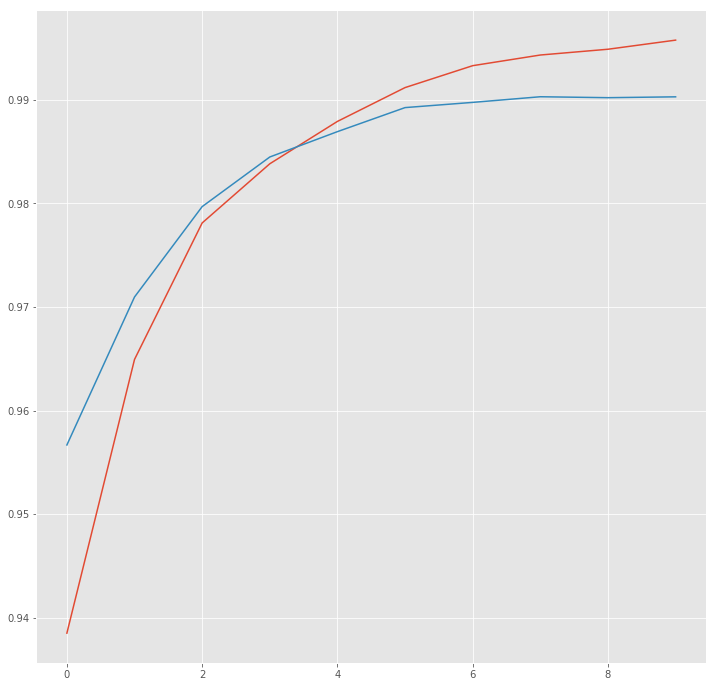

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [29]:
y_pred = model.predict([X_word_te, np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

In [30]:
i = 202
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
Bây_giờ        : O     O
bé             : O     O
chị            : O     O
Rơ             : PERSON PERSON
Châm           : PERSON PERSON
Dâu            : PERSON PERSON
đang           : O     O
học            : O     O
lớp            : O     O
3              : O     O
,              : O     O
còn            : O     O
thằng          : O     O
em             : O     O
Rơ             : PERSON PERSON
Châm           : PERSON PERSON
Tô             : PERSON PERSON
học            : O     O
lớp            : O     O
1              : O     ORGANIZATION
Trường         : ORGANIZATION ORGANIZATION
tiểu_học       : ORGANIZATION ORGANIZATION
Nghĩa_Hoà      : ORGANIZATION ORGANIZATION
.              : O     O
